In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess_data(path='dataset_wparticipant_v2.csv', sample_size=12000, random_state=123):
    """
    Preprocesses data by loading a sample, converting specific columns to binary, applying one-hot encoding, 
    and splitting into train/test sets.
    
    Args:
        path (str): Path to the dataset CSV file.
        sample_size (int): Number of rows to load.
        random_state (int): Random state for reproducibility.
        
    Returns:
        pd.DataFrame, pd.DataFrame: Training and test datasets.
    """
    # Total rows in the dataset
    total_rows = 6034221

    # Define rows to skip for random sampling
    if sample_size >= total_rows:
        print("The number of requested rows is greater than or equal to the total rows. Loading all data.")
        skip_rows = None
    else:
        rng = np.random.default_rng(random_state)
        skip_rows = set(np.random.choice(range(1, total_rows + 1), size=total_rows - sample_size, 
                                         replace=False)) #random_state=random_state
    
    # Load sampled data
    data = pd.read_csv(path, sep=';', skiprows=lambda x: x in skip_rows)
    
    # Filter invalid or zero total price rows
    data = data[data["sw_total_price_wdiscount"].notna() & (data["sw_total_price_wdiscount"] > 0)]
    data["target_amount"] = data["sw_total_price_wdiscount"] - 1

    # Total amount is a direct numeric feature. Scale non-direct numeric features (lot to ad ratio)
    data["sum_lot_ad_ratio"] = data["total_amount"]/data["ad_total_sum"]
    data["count_lot_ad_ratio"] = data["total_count"]/data["ad_lots_count"]
    
    # Select relevant columns
    cols_to_keep = [
        "target_amount", "total_amount", "sum_lot_ad_ratio", "count_lot_ad_ratio",
        "is_union_lots", "is_dumping", "plan_trade_method_id", "fact_trade_method_id", 
        "psd_sign", "is_consulting_services", "single_org_sign", "is_light_industry",
        "is_construction_work", "is_disable_person_advertisement", "ad_trade_method_id",
        "ad_subject_type_id", "ad_trade_type_id", "ad_disable_person_id", "ad_single_org_sign",
        "ad_is_light_industry", "ad_is_construction_work", "ad_purchase_type_id",
        "participant_creation_date", "participant_is_have_website", "participant_is_quazi", 
        "participant_is_national_company", "participant_kopf_code", 
        "participant_is_association_with_disabilities", "participant_registration_year",
        "participant_is_supplier", "participant_krp_code", "participant_parent_company",
        "participant_branches", "participant_oked_list", "participant_kse_code",
        "participant_is_world_company", "participant_is_state_monopoly",
        "participant_is_natural_monopoly"
    ]
    data = data[cols_to_keep]

    # 1. Transform 'psd_sign' to binary
    data['pds_sign'] = data['psd_sign'].apply(lambda x: 0 if x == 0 else 1)

    # 2. Transform 'participant_parent_company' to 'is_subsidiary'
    data['is_subsidiary'] = data['participant_parent_company'].apply(lambda x: 0 if pd.isnull(x) else 1)

    # 3. Transform 'participant_branches' to 'is_parent_company'
    data['is_parent_company'] = data['participant_branches'].apply(lambda x: 0 if pd.isnull(x) else 1)

    # Drop original columns after transformation
    data.drop(columns=["participant_parent_company", "participant_branches"], inplace=True)

    # categorical features are columns starting from "is_union_lots" and apply one-hot encoding
    cat_columns = data.columns[data.columns.get_loc("is_union_lots"):]
    data = pd.get_dummies(data, columns=cat_columns, drop_first=True)

    # 5. Remove rows with any NaN values
    # data = data.dropna()

    # 6. Train-test split
    X = data.drop(columns=["target_amount"])  # Features
    y = data["target_amount"]                # Target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    return X_train, X_test, y_train, y_test


In [61]:
X_train, X_test, y_train, y_test = preprocess_data(random_state = 4)

In [62]:
X_train.shape, X_test.shape

((8696, 302), (2175, 302))

Random Forest Regression Results:
Mean Squared Error: 48484780186407.78
R² Score: 0.9657

Top 20 Important Features:
                                Feature  Importance
0                          total_amount    0.956546
34             is_construction_work_4.0    0.006228
20           fact_trade_method_id_188.0    0.005904
31                  single_org_sign_3.0    0.005507
231         participant_oked_list_84130    0.004023
70                 ad_single_org_sign_3    0.002907
46               ad_trade_method_id_188    0.002535
111  participant_registration_year_2023    0.002526
68                 ad_single_org_sign_1    0.002322
88        participant_is_have_website_1    0.001709
230         participant_oked_list_84120    0.001595
50                   ad_trade_type_id_3    0.001178
78            ad_is_construction_work_4    0.001079
25                           psd_sign_9    0.001065
110  participant_registration_year_2022    0.001015
76            ad_is_construction_work_1    0.000707

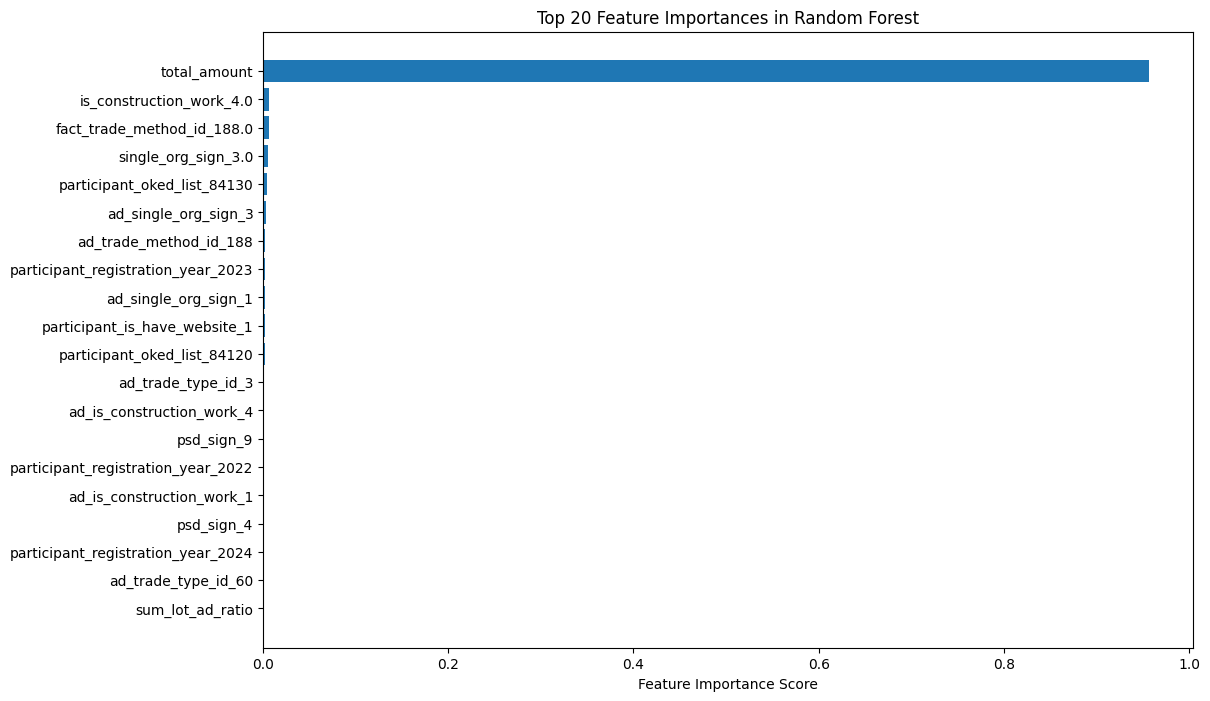

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    random_state=123,      # Reproducibility
    max_depth=15,          # Limit tree depth to avoid overfitting
    n_jobs=-1              # Use all CPU cores
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Regression Results:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.4f}")

feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Convert to a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display Top Features
print("\nTop 20 Important Features:")
print(feature_importance_df.head(20))

# Plot Top 20 Feature Importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances in Random Forest")
plt.xlabel("Feature Importance Score")
plt.show()